In [1]:
# This notebook uses a dataset from the paper: 'From Group to Individual Labels using Deep Features', Kotzias et. al,. KDD 2015

In [2]:
# Imports
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

In [3]:
# Read in the data
data = pd.read_csv('https://github.com/SBodapati11/Sentiment-Prediction/blob/main/yelp_labelled.txt?raw=true', sep="\t", header=None)
data.columns = ['Review', 'Sentiment']

In [4]:
# A sentiment score of 1 indicates a positive rating and 0 indicates a negative rating
data.head()

,Review,Sentiment
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [5]:
# Create directories for each class
os.mkdir('/content/train/')
os.mkdir('/content/train/0/')
os.mkdir('/content/train/1/')

In [6]:
# Go through each example and create a file with the text under the appropriate class
for index, row in data.iterrows():
  path = '/content/train/' + str(row['Sentiment']) + '/' + str(index) + '.txt'
  with open(path, 'w') as f:
    f.write(row['Review'])

In [7]:
# Read in the training data as a tensorflow.data.Dataset
train_dataset = tf.keras.utils.text_dataset_from_directory('/content/train', labels = 'inferred',
                                                         label_mode = 'binary',
                                                         batch_size = 32,
                                                         validation_split=0.2,
                                                         subset="training",
                                                         seed=10,
                                                         shuffle = True)

# Read in the testing data as a tensorflow.data.Dataset 
test_dataset = tf.keras.utils.text_dataset_from_directory('/content/train', labels = 'inferred',
                                                         label_mode = 'binary',
                                                         batch_size = 32,
                                                         validation_split=0.2,
                                                         subset="validation",
                                                         seed=10,
                                                         shuffle = True)

Found 1000 files belonging to 2 classes.
Using 800 files for training.
Found 1000 files belonging to 2 classes.
Using 200 files for validation.


In [8]:
# Perform standardization, tokenization, and vectorization of the data
# Standardization removes punctuation and converts to lowercase
# Tokenization splits the text using whitespace as separator
# Vectorization assigns an integer to each word and returns text as tensors

# Create the vectorization layer
vectorization_layer = tf.keras.layers.TextVectorization(max_tokens=10000, 
                                                        output_mode = 'int',
                                                        output_sequence_length=250)

# Add the layer to the text to create a dictionary
vectorization_layer.adapt(train_dataset.map(lambda text, labels: text))

# Function that applies the vectorization layer to a dataset
def text_vectorization(text, label):
  text = tf.expand_dims(text, -1)
  return vectorization_layer(text), label

# Apply the vectorization to each training and testing set
tensor_train_data = train_dataset.map(text_vectorization)
tensor_test_data = train_dataset.map(text_vectorization)

In [9]:
# Optimize the datasets for performance
train_data = tensor_train_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = tensor_test_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
# Function to create and return a model
def create_model(num_LSTM_layers=64, num_dense_layers=64, activation_function='relu', 
                 learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07):
  # Create the model
  model = tf.keras.Sequential([tf.keras.layers.Embedding(input_dim=len(vectorization_layer.get_vocabulary()),
                                                        output_dim=1,
                                                        mask_zero=True),
                              tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(num_LSTM_layers)),
                              tf.keras.layers.Dense(num_dense_layers, activation=activation_function),
                              tf.keras.layers.Dropout(0.2),
                              tf.keras.layers.Dense(1)])
  
  # Compile the model
  model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate,
                                                   beta_1=beta_1,
                                                   beta_2=beta_2,
                                                   epsilon=epsilon),
                metrics=['accuracy'])
  
  # Train the model over the training data
  history = model.fit(train_data, epochs=6)
  
  return model, history

In [14]:
# Function to plot the accuracies
def plot_accuracies(model_name, history):
  plt.plot(history.history['accuracy'])
  plt.xlabel('Epochs')
  plt.ylabel('Training Accuracy')
  plt.title('History of ' + model_name)

Epoch 1/6
25/25 [==============================] - 13s 17ms/step - loss: 0.6937 - accuracy: 0.5063
Epoch 2/6
25/25 [==============================] - 0s 13ms/step - loss: 0.6928 - accuracy: 0.5063
Epoch 3/6
25/25 [==============================] - 0s 13ms/step - loss: 0.6862 - accuracy: 0.5063
Epoch 4/6
25/25 [==============================] - 0s 13ms/step - loss: 0.6517 - accuracy: 0.5437
Epoch 5/6
25/25 [==============================] - 0s 13ms/step - loss: 0.5384 - accuracy: 0.6075
Epoch 6/6
25/25 [==============================] - 2s 9ms/step - loss: 0.3078 - accuracy: 0.9013
Test Loss: 0.3078034520149231
Test Accuracy: 0.9012500047683716


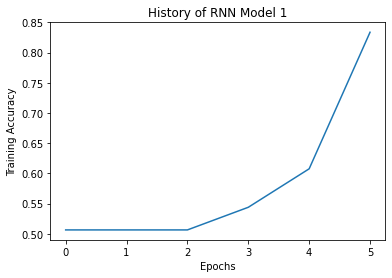

In [15]:
# Create and train the RNN model with default values and plot the accuracies
model1, history1 = create_model()
plot_accuracies("RNN Model 1", history1)

# Evaluate the model on the test data and output the loss and accuracy
test_loss, test_acc = model1.evaluate(test_data)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

Epoch 1/6
25/25 [==============================] - 7s 13ms/step - loss: 0.6975 - accuracy: 0.5063
Epoch 2/6
25/25 [==============================] - 0s 13ms/step - loss: 0.6355 - accuracy: 0.6837
Epoch 3/6
25/25 [==============================] - 0s 13ms/step - loss: 0.2289 - accuracy: 0.9200
Epoch 4/6
25/25 [==============================] - 0s 13ms/step - loss: 0.1863 - accuracy: 0.9400
Epoch 5/6
25/25 [==============================] - 0s 13ms/step - loss: 0.0874 - accuracy: 0.9737
Epoch 6/6
25/25 [==============================] - 4s 6ms/step - loss: 0.0134 - accuracy: 0.9962
Test Loss: 0.013440613634884357
Test Accuracy: 0.9962499737739563


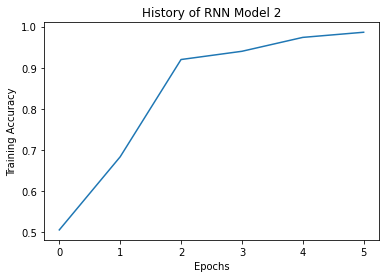

In [16]:
# Create and train the RNN model with learning_rate=0.001 and beta_2=0.99
model2, history2 = create_model(learning_rate=0.01, beta_2=0.99)
plot_accuracies("RNN Model 2", history2)

# Evaluate the model on the test data and output the loss and accuracy
test_loss, test_acc = model2.evaluate(test_data)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

Epoch 1/6
25/25 [==============================] - 8s 23ms/step - loss: 0.6934 - accuracy: 0.5063
Epoch 2/6
25/25 [==============================] - 1s 24ms/step - loss: 0.6887 - accuracy: 0.5063
Epoch 3/6
25/25 [==============================] - 1s 21ms/step - loss: 0.6594 - accuracy: 0.5100
Epoch 4/6
25/25 [==============================] - 1s 25ms/step - loss: 0.5234 - accuracy: 0.6475
Epoch 5/6
25/25 [==============================] - 1s 27ms/step - loss: 0.3951 - accuracy: 0.8475
Epoch 6/6
25/25 [==============================] - 5s 6ms/step - loss: 0.2219 - accuracy: 0.9300
Test Loss: 0.22186973690986633
Test Accuracy: 0.9300000071525574


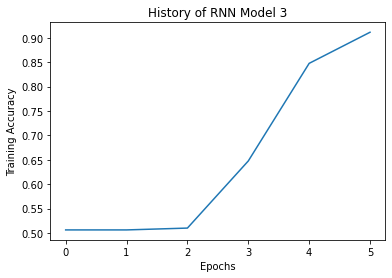

In [17]:
# Create and train the RNN model with beta_1=0.8 and epsilon=1e-06
model3, history3 = create_model(beta_1=0.8, epsilon=1e-06)
plot_accuracies("RNN Model 3", history3)

# Evaluate the model on the test data and output the loss and accuracy
test_loss, test_acc = model3.evaluate(test_data)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

Epoch 1/6
25/25 [==============================] - 9s 13ms/step - loss: 0.6935 - accuracy: 0.5063
Epoch 2/6
25/25 [==============================] - 0s 15ms/step - loss: 0.6931 - accuracy: 0.5063
Epoch 3/6
25/25 [==============================] - 0s 14ms/step - loss: 0.6930 - accuracy: 0.5063
Epoch 4/6
25/25 [==============================] - 0s 14ms/step - loss: 0.6917 - accuracy: 0.5063
Epoch 5/6
25/25 [==============================] - 0s 15ms/step - loss: 0.6771 - accuracy: 0.5063
Epoch 6/6
25/25 [==============================] - 3s 10ms/step - loss: 0.4834 - accuracy: 0.7387
Test Loss: 0.48344817757606506
Test Accuracy: 0.7387499809265137


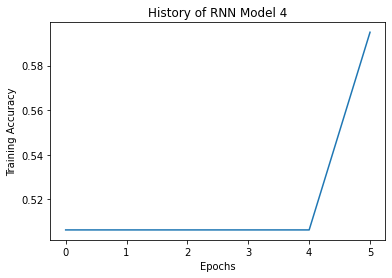

In [18]:
# Create and train the RNN model with num_LSTM_layers=32 and num_dense_layers=32
model4, history4 = create_model(num_LSTM_layers=32, num_dense_layers=32)
plot_accuracies("RNN Model 4", history4)

# Evaluate the model on the test data and output the loss and accuracy
test_loss, test_acc = model4.evaluate(test_data)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

Epoch 1/6
25/25 [==============================] - 8s 14ms/step - loss: 0.7180 - accuracy: 0.5050
Epoch 2/6
25/25 [==============================] - 0s 13ms/step - loss: 0.7175 - accuracy: 0.5013
Epoch 3/6
25/25 [==============================] - 0s 13ms/step - loss: 0.7129 - accuracy: 0.4988
Epoch 4/6
25/25 [==============================] - 0s 13ms/step - loss: 0.7079 - accuracy: 0.5000
Epoch 5/6
25/25 [==============================] - 0s 13ms/step - loss: 0.7008 - accuracy: 0.5138
Epoch 6/6
25/25 [==============================] - 3s 5ms/step - loss: 0.5714 - accuracy: 0.6050
Test Loss: 0.5713984966278076
Test Accuracy: 0.6050000190734863


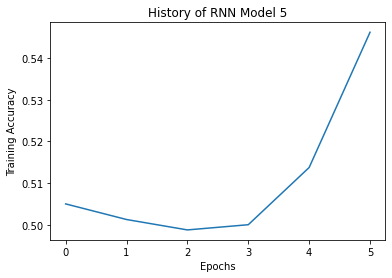

In [19]:
# Create and train the RNN model with activation_function='softmax'
model5, history5 = create_model(activation_function='sigmoid')
plot_accuracies("RNN Model 5", history5)

# Evaluate the model on the test data and output the loss and accuracy
test_loss, test_acc = model5.evaluate(test_data)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

In [22]:
# Use the best model and find 10 misclassified examples in the test dataset
# For the predictions, a value >= 0 indicates a positive sentiment and < 0 indicates negative
predicted = model2.predict(test_data)

count = 0
i = 0
for text, true_label in test_dataset.take(3):
  if count == 10:
    break
  for i in range(len(text)):
    if count == 10:
      break
    predicted_class = 0
    if predicted[i][0] >= 0:
      predicted_class = 1
    if true_label.numpy()[i] != predicted_class:
      print('Text: ', text.numpy()[i])
      print('True Label: ', true_label.numpy()[i])
      print('Predicted Label: ', predicted_class)
      print()
      count += 1

25/25 [==============================] - 0s 7ms/step
Text:  b'Service stinks here!'
True Label:  [0.]
Predicted Label:  1

Text:  b"The whole experience was underwhelming, and I think we'll just go to Ninja Sushi next time."
True Label:  [0.]
Predicted Label:  1

Text:  b'Their regular toasted bread was equally satisfying with the occasional pats of butter... Mmmm...!'
True Label:  [1.]
Predicted Label:  0

Text:  b'It was pretty gross!'
True Label:  [0.]
Predicted Label:  1

Text:  b"If the food isn't bad enough for you, then enjoy dealing with the world's worst/annoying drunk people."
True Label:  [0.]
Predicted Label:  1

Text:  b'Our server was super nice and checked on us many times.'
True Label:  [1.]
Predicted Label:  0

Text:  b'The pan cakes everyone are raving about taste like a sugary disaster tailored to the palate of a six year old.'
True Label:  [0.]
Predicted Label:  1

Text:  b"Overall, I don't think that I would take my parents to this place again because they made mos

In [38]:
# Get the same training and testing data that we used earlier
x_train, x_test, y_train, y_test = [], [], [], []

# Get the training data
for text_batch, label_batch in train_dataset:
  for i in range(len(text_batch)):
    x_train.append(text_batch[i].numpy())
    y_train.append(int(label_batch[i].numpy()[0]))

# Get the testing data
for text_batch, label_batch in test_dataset:
  for i in range(len(text_batch)):
    x_test.append(text_batch[i].numpy())
    y_test.append(int(label_batch[i].numpy()[0]))

In [39]:
# Perform vectorization of the words. By default, CountVectorizers 
# lowers all the characters and removes punctuation
vectorizer = CountVectorizer()
x_train_arr = vectorizer.fit_transform(x_train).toarray()
x_test_arr = vectorizer.transform(x_test).toarray()

In [40]:
# Creates the Gaussian Naive Bayes Classifier with given parameters, 
# trains it over the training data, and returns the accuracy
# over the testing data
def create_model(alpha=1.0, fit_prior=True, class_prior=None):
  model = MultinomialNB(alpha=alpha, fit_prior=fit_prior, class_prior=class_prior)
  model.fit(x_train_arr, y_train)
  return model, model.score(x_test_arr, y_test)

In [41]:
# Create the model with default parameters
model1, acc1 = create_model()
acc1

0.775

In [42]:
# Create the model with alpha=1e-10
model2, acc2 = create_model(alpha=1e-10)
acc2

0.735

In [43]:
# Create the model with fit_prior=False (sets equal prior weights)
model3, acc3 = create_model(fit_prior=False)
acc3

0.78

In [44]:
# Create the model with class_prior=[0.25, 0.75]
model4, acc4 = create_model(class_prior=[0.25, 0.75])
acc4

0.785

In [45]:
# Create the model with class_prior=[0.75, 0.25]
model5, acc5 = create_model(class_prior=[0.75, 0.25])
acc5

0.74

In [48]:
# Use the best model and find 10 misclassified examples in the test dataset
predicted = model4.predict(x_test_arr)

count = 0
i = 0
while count < 10:
  if predicted[i] != y_test[i]:
    print('Text: ', x_test[i])
    print('True Label: ', y_test[i])
    print('Predicted Label: ', predicted[i])
    print()
    count += 1
  i += 1

Text:  b"The ambiance isn't much better."
True Label:  0
Predicted Label:  1

Text:  b'The server was very negligent of our needs and made us feel very unwelcome... I would not suggest this place!'
True Label:  0
Predicted Label:  1

Text:  b"The food wasn't good."
True Label:  0
Predicted Label:  1

Text:  b'The Burrittos Blah!'
True Label:  0
Predicted Label:  1

Text:  b'The service was a bit lacking.'
True Label:  0
Predicted Label:  1

Text:  b'it was a drive to get there.'
True Label:  0
Predicted Label:  1

Text:  b"I wouldn't return."
True Label:  0
Predicted Label:  1

Text:  b'What SHOULD have been a hilarious, yummy Christmas Eve dinner to remember was the biggest fail of the entire trip for us.'
True Label:  0
Predicted Label:  1

Text:  b'Today was my first taste of a Buldogis Gourmet Hot Dog and I have to tell you it was more than I ever thought possible.'
True Label:  1
Predicted Label:  0

Text:  b'If you want a sandwich just go to any Firehouse!!!!!'
True Label:  1
Pre